In [1287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow import one_hot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Data Prepocessing

## Loading

In [1288]:
sample = pd.read_excel(r"Data\training_sample\trump_sample.xls")[['text','sentiment']].rename(columns={'sentiment': "labels", "text":"data"})
sample['labels_n'] = sample['labels']+1
df = sample[['data', 'labels_n']]
print('data shape:', df.shape)
df.head()

data shape: (2434, 2)


,data,labels_n
0,#Opinion| #Trump and Nobel Prize: Make Deals N...,1.0
1,"If Biden really wants to secure a strong vote,...",1.0
2,"RT @BetteMidler: #Trump said Nancy Pelosi is ""...",1.0
3,RT @Emolclause: #BREAKING:A new global survey ...,0.0
4,@ddale8 Those few times when #Trump is too ign...,0.0


## Cleaning texts

In [1289]:
clear_text = [str(df.data.iloc[i]).replace('#', '') for i in range(len(df.data))]
clear_text = [str(clear_text[i]).replace(r"*", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"'", '') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).replace(r"&amp;", ' and ') for i in range(len(clear_text))]
clear_text = [str(clear_text[i]).lower() for i in range(len(clear_text))]
(print(clear_text[5]))

rt @jerusalem_post: breaking: us president donald trump is expected to announce a normalization agreement between israel and bahrain tod…


## Stemming

In [1290]:
porter = PorterStemmer()
def stemsentence(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
text_stemmed = [stemsentence(txt) for txt in clear_text]
print(text_stemmed[5])

rt @ jerusalem_post : break : us presid donald trump is expect to announc a normal agreement between israel and bahrain tod… 


In [1291]:
df['ready_data'] = text_stemmed
df.shape

(2434, 3)

## Preparing targets

In [1292]:
Y = np.array(one_hot(df.labels_n, depth=3))
print('Y=',Y[:10])
print('number of missing values:',np.isnan(Y).sum())

Y= [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
number of missing values: 0


## Train-test split

In [1293]:
# df_train, df_test, Y_train, Y_test = train_test_split(df.ready_data, Y, test_size=0.25)
df_train, df_test, Y_train, Y_test = train_test_split(df.data, Y, test_size=0.25)

## Tokenizing tweet texts

In [1294]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [1295]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 8934 unique tokens.


## Padding sequences to the same length

In [1296]:
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

T = data_train.shape[1]

Shape of data train tensor: (1825, 106)


In [1297]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (609, 106)


## Class weights to use in the model

In [1298]:
neg = (Y_train[:,0] == 1).sum()
neu = (Y_train[:,1] == 1).sum()
pos = (Y_train[:,2] == 1).sum()
total = len(Y_train)

print("neg:", neg/total)
print("neu:", neu/total)
print("pos:", pos/total)
weight_for_0 = (1/neg)*(total)/3
weight_for_1 = (1/neu)*(total)/3
weight_for_2 = (1/pos)*(total)/3

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
print(class_weight)

neg: 0.42684931506849316
neu: 0.42356164383561645
pos: 0.1473972602739726
{0: 0.7809157038938811, 1: 0.7869771453212593, 2: 2.261462205700124}


# RNN (LSTM) Model

## Creating the model

In [1299]:
D = 20
M = 15

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training model...")

r = model.fit(data_train, Y_train, epochs=12, class_weight=class_weight, batch_size=32, validation_data=(data_test, Y_test))

Training model...
Epoch 1/12
58/58 [==============================] - 3s 46ms/step - loss: 1.0950 - accuracy: 0.4674 - val_loss: 1.0896 - val_accuracy: 0.5304
Epoch 2/12
58/58 [==============================] - 2s 41ms/step - loss: 1.0381 - accuracy: 0.5677 - val_loss: 1.0541 - val_accuracy: 0.4548
Epoch 3/12
58/58 [==============================] - 2s 42ms/step - loss: 0.8126 - accuracy: 0.5721 - val_loss: 0.8822 - val_accuracy: 0.5386
Epoch 4/12
58/58 [==============================] - 2s 41ms/step - loss: 0.6017 - accuracy: 0.7233 - val_loss: 0.7667 - val_accuracy: 0.7225
Epoch 5/12
58/58 [==============================] - 2s 42ms/step - loss: 0.4014 - accuracy: 0.9184 - val_loss: 0.7577 - val_accuracy: 0.7176
Epoch 6/12
58/58 [==============================] - 2s 40ms/step - loss: 0.2719 - accuracy: 0.9507 - val_loss: 0.7505 - val_accuracy: 0.7291
Epoch 7/12
58/58 [==============================] - 2s 42ms/step - loss: 0.1898 - accuracy: 0.9660 - val_loss: 0.6265 - val_accuracy: 0.

## Log-likelihood and accuracy per iteration

In [1301]:
N = Y_train.shape[0]

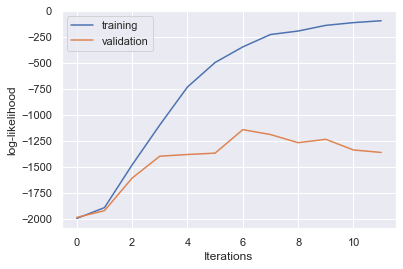

In [1302]:
plt.plot(-np.array(r.history['loss'])*N, label='training')
plt.plot(-np.array(r.history['val_loss'])*N, label='validation')
plt.ylabel('log-likelihood')
plt.xlabel('Iterations')
plt.legend()

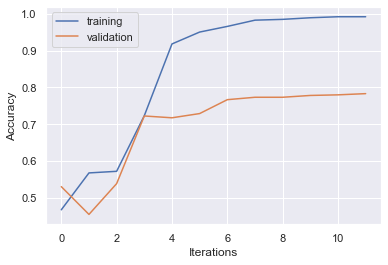

In [1303]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='training')
plt.plot(r.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()

## Confusion Matrix

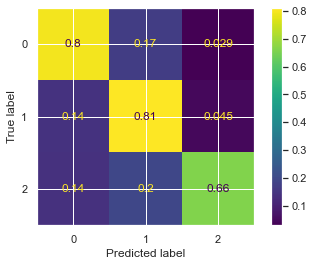

In [1304]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict(data_test)
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), normalize='true')
ConfusionMatrixDisplay(matrix).plot()

# Prediction of sentiment values for the rest of tweets

## Loading the new data

In [35]:
import os
filelist = os.listdir(r'Data\raw')
new_files = []
for f in filelist:
    if f.startswith('tr'):
        new_files.append(f)
print(new_files)

['trump_09-07 - 09-21.pickle', 'trump_09-22 - 10-13.pickle', 'trump_10-13 - 10-27.pickle']


In [36]:
df_list = [pd.read_pickle('Data\\raw\\'+new_files[i]) for i in range(3)]
for d in df_list:
    if 'text' not in d.columns:
        d['text'] = d['full_text']
        d['retweeted_status-text'] = d['retweeted_status-full_text']
df_new = pd.concat(df_list)[['text', 'retweeted_status-text']].reset_index()
for t in df_new.index:
    if df_new.loc[t, 'text'].startswith('RT'):
        df_new.loc[t, 'text'] = df_new.loc[t, 'retweeted_status-text']


In [37]:
print(df_new.shape)

(615468, 3)


## Same preprocessing steps for the new data

In [188]:
#clear_text = [str(df_new.text.iloc[i]).replace('#', '') for i in range(len(df_new.text))]
#clear_text = [str(clear_text[i]).replace(r"*", '') for i in range(len(clear_text))]
#clear_text = [str(clear_text[i]).replace(r"'", '') for i in range(len(clear_text))]
##clear_text = [str(clear_text[i]).replace(r"&amp;", ' and ') for i in range(len(clear_text))]
#clear_text = [str(clear_text[i]).lower() for i in range(len(clear_text))]
#text_stemmed = [stemsentence(txt) for txt in clear_text]
#print(text_stemmed[5])

hundr of truck and car line up on the highway for an oregon for trump road ralli trump2020 trump http : //t.co/hluhxv3gfv 


In [196]:
#df_new['ready_data'] = text_stemmed

In [415]:
#df_new['ready_data'] = text_stemmed
#sequences_new = tokenizer.texts_to_sequences(df_new.ready_data)
#data_new = pad_sequences(sequences_new, maxlen=T)

In [1305]:
sequences_new = tokenizer.texts_to_sequences(df_new.text.astype(str))
data_new = pad_sequences(sequences_new, maxlen=T)

## Predicting values

In [1306]:
predictions = np.argmax(model.predict(data_new),axis=1)
print("NEW DATA", "\n", "neg: ",(predictions==0).sum()/predictions.shape[0],"\n" "neut: ",(predictions==1).sum()/predictions.shape[0],"\n", "pos: ",(predictions==2).sum()/predictions.shape[0])

NEW DATA 
 neg:  0.20735927781785568 
neut:  0.7561530412629088 
 pos:  0.036487680919235446


In [1307]:
output_df = pd.concat(df_list).reset_index()
output_df['sentiment'] = predictions-1

In [1308]:
output_df.sentiment.value_counts()

 0    465388
-1    127623
 1     22457
Name: sentiment, dtype: int64

## Saving new file

In [1310]:
#output_df.to_pickle(r'Data\classified_tweets\trump_classified.pickle')